Let's imagine we have two distributions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
import scipy.stats

In [3]:
distrib_positive = scipy.stats.norm(loc=1, scale=2)
distrib_negative = scipy.stats.norm(loc=-1, scale=2)

Let's draw two sets of samples from these distributions and plot them.

In [4]:
positives = distrib_positive.rvs(size=100) 
negatives = distrib_negative.rvs(size=100)

Let's build a dataframe and plot them.

In [5]:
df = pd.DataFrame({'values': np.concatenate((positives, negatives)), 
                   'true_label': [True] * positives.size + [False] * positives.size})

Let's add a column that makes use of the fact that we can cast boolean values to 0 or 1.

In [6]:
df['numerical_label'] = df['true_label'].astype(float)

df.head()

,values,true_label,numerical_label
0,0.863974,True,1.0
1,2.066209,True,1.0
2,1.477000,True,1.0
3,-2.070876,True,1.0
4,5.881839,True,1.0


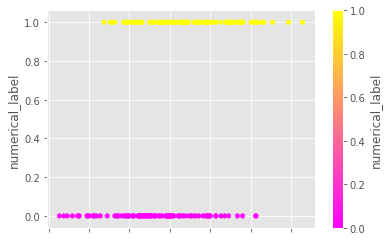

In [7]:
df.plot.scatter(x='values', y='numerical_label', c='numerical_label', cmap='spring')

We can see that there is a lot of overlap between the two labels.

A simple binary classifier would in this case be a threshold based mechanism. What is above the threshold is classified as positive, what is below is classified as negative. 

Using this procedure and setting the threshold at a value of 0, we can predict the following labels:

In [8]:
df['predicted'] = (df['values'] > 0.).astype(float)

In [9]:
df.head()

,values,true_label,numerical_label,predicted
0,0.863974,True,1.0,1.0
1,2.066209,True,1.0,1.0
2,1.477000,True,1.0,1.0
3,-2.070876,True,1.0,0.0
4,5.881839,True,1.0,1.0


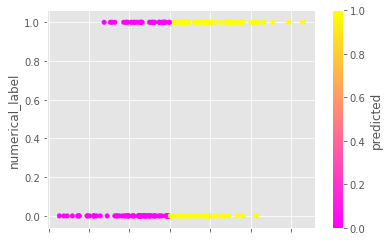

In [10]:
df.plot.scatter(x='values', y='numerical_label', c='predicted', cmap='spring')

Now, how do we say that the classifier works well or not? 

Standard metrics can be grouped into the following two "explanations":


- The classifier is right:
    - True Positive 
    - False Negatives
- The classifier is wrong:
    - True Negatives (top left blue dots)
    - False Positives (bottom right yellow dots)

Let's compute all of these:

In [11]:
def make_report(df):
    """Computes TP, FN, TN and FP from the dataframe."""
    TP = (df['true_label'] == df['predicted']) & (df['true_label'])
    FN = (df['true_label'] == df['predicted']) & (~df['true_label'])
    TN = (df['true_label'] != df['predicted']) & (df['true_label'])
    FP = (df['true_label'] != df['predicted']) & (~df['true_label'])
    return "TP: {}, FN: {}, TN: {}, FP: {}".format(TP.sum(), FN.sum(), TN.sum(), FP.sum())

In [12]:
make_report(df)

'TP: 66, FN: 67, TN: 34, FP: 33'

Now, the question is: what happens if we move the threshold up or down?

First, let's move the threshold up. We only classify as positive the really high values.

In [13]:
df['predicted'] = (df['values'] > 2.).astype(float)
make_report(df)

'TP: 35, FN: 90, TN: 65, FP: 10'

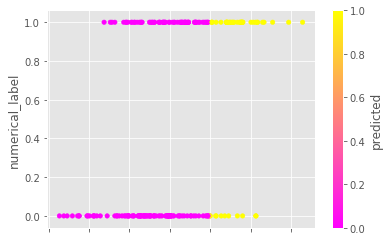

In [14]:
df.plot.scatter(x='values', y='numerical_label', c='predicted', cmap='spring')

We now have less false positives at the expense of less true positives.

What if we move the threshold down?

In [15]:
df['predicted'] = (df['values'] > -2.).astype(float)
make_report(df)

'TP: 92, FN: 27, TN: 8, FP: 73'

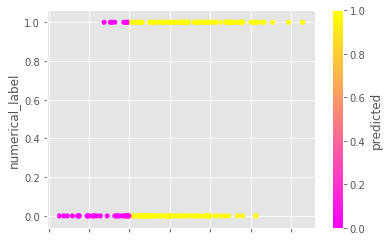

In [16]:
df.plot.scatter(x='values', y='numerical_label', c='predicted', cmap='spring')

Compared to our 0 threshold, we now have more false positives but also more true positives.

It turns out that one way of vizualizing this changing behaviour is to plot the famous ROC curve.

To do that, we will introduce normalized "rates", so that we become able to compare different classifiers on the same curve.

The abscissa will be the *false positive rate*, the number of false positive samples divided by the negative condition samples.

The y axis will be the *true positive rate* the number of true positive samples divided by the number of true condition samples.

Intuitively, why are those statistics chosen? Difficult to say, but we would like the true positive rate as high as possible, while the false positive rate should be as low as possible.

In [17]:
def compute_roc_point(df):
    """Returns (FPR, TPR) from the dataframe."""
    TP = (df['true_label'] == df['predicted']) & (df['true_label'])
    T = df['true_label'].sum()
    FP = (df['true_label'] != df['predicted']) & (~df['true_label'])
    F = (~df['true_label']).sum()
    return FP.sum()/F, TP.sum()/T

In [18]:
compute_roc_point(df)

(0.73, 0.92)

By varying the threshold, we can now draw a curve.

In [19]:
roc_curve = []
for thresh in np.arange(-5, 5, 0.05):
    df['predicted'] = (df['values'] > thresh).astype(float)
    roc_curve.append(compute_roc_point(df))

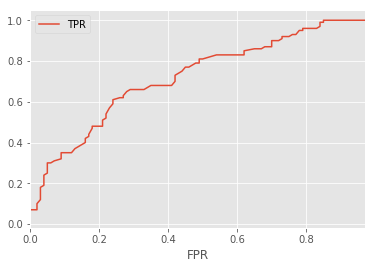

In [20]:
roc_df = pd.DataFrame(data=roc_curve, columns=['FPR', 'TPR'])
roc_df.plot.line(x='FPR', y='TPR')

One of the interesting things here is that the lowest threshold yields the top right point while the highest threshold yields the bottom left point.

Let's put all of this in an animation.

In [21]:
import matplotlib.animation as animation
from IPython.display import display, HTML

fig, axes = plt.subplots(ncols=2)
axes[0].plot(roc_df['FPR'], roc_df['TPR'])
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')

def data_gen(t=0):
    for thresh in np.arange(-5, 5, .25):
        df['predicted'] = (df['values'] > thresh).astype(float)
        yield df

def update(df):
    x, y = compute_roc_point(df)
    m = axes[0].plot(x, y, 'ko')
    axes[1].scatter(x=df['values'], y=df['numerical_label'], c=df['predicted'], cmap='spring')
    return m


ani = animation.FuncAnimation(fig, update, data_gen, interval=100)
display(HTML(ani.to_jshtml()))
plt.close(fig)